In [1]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import adjusted_rand_score, silhouette_score
from sklearn import metrics
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import FunctionTransformer

# from math import comb
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

from pathlib import Path
dir_data = Path('./data')

C:\Users\pabma\AppData\Local\Temp\ipykernel_6472\1413361061.py:25: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [2]:
# importar lo que falta!!!
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# entender argumentos de la función
def score_dataset(X, y, model=XGBClassifier()):
    # Label encoding for categoricals
    # Existe otra forma de hacer eso?
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error) # Y esto?
    score = cross_val_score(
        model, X, y, cv=5, scoring="accuracy",
    )
    score = score.mean()
#     score = np.sqrt(score)
    return score

def do_pca(X, n):
    '''
    Given a df or array X and a number of components n, gives the model and the
    transformed features as output (Watchout: Inside we standardize)
    '''
    # Before PCA is a must to standardize features
    # poner en una pipeline
    # sc = StandardScaler()
    # X = sc.fit_transform(X)
    # pca = PCA(n_components=n)
    # X_pca = pca.fit_transform(X)
    pipe = make_pipeline(StandardScaler, PCA(n_components=n))
    X_pca = pipe.fit_transform(X)
    pca = pipe["pca"]
    return pca, X_pca

# entender
def pca_importance(pca):
    '''
    Given a PCA model, percentage of importance for each component is showed.
    '''
    components = pca.components_  # Axis of maximum variation
    n = len(components)
    x = np.arange(n)
    values = pca.explained_variance_ratio_ * 100
    acvalues = np.cumsum(values)

    fig, ax = plt.subplots(figsize=(18, 6))
    ax.bar(x, values)
    ax.plot(x, acvalues)
    for i in x:
        ax.annotate("{}%".format(round(values[i], 2)), (i-.1, values[i]),
                    fontsize=12)
        ax.annotate("{}%".format(round(acvalues[i], 2)), (i-.1, acvalues[i]),
                    fontsize=12)
    ax.set_xlabel("Number of Components")
    ax.set_ylabel("Variability (%)")

# Introducción

En esta práctica vamos a cubrir los siguientes puntos:

   * Caso de Uso
   * Reducción de la Dimensionalidad
        - Aplicación de PCA para reducción del número de variables
        - Interpretación de Resultados de PCA
   * Algoritmos de Clustering
        - Algoritmos Jerárquicos e interpretación de resultados
        - K-Means e interpretación de resultados
   * Métricas
        - Cálculo de índices externos
        - Uso de métricas para determinar parámetros de modelo

# Caso de Uso

Para el desarrollo de esta práctica se utilizará el dataset disponible en `mobile_data.csv`. Este es un conjunto de datos tomado de la popular plataforma de ciencia de datos [Kaggle](https://www.kaggle.com/). Accediendo al siguiente [enlace](https://www.kaggle.com/iabhishekofficial/mobile-price-classification) se tiene la fuente.

La descripción que encontramos es la siguiente:

'''
Bob ha creado su propia empresa de móviles. Quiere plantar cara a grandes empresas como Apple, Samsung, etc.

No sabe cómo calcular el precio de los móviles que fabrica su empresa. En este mercado tan competitivo de la telefonía móvil no puede simplemente suponer cosas. Para resolver este problema, recopila datos de ventas de teléfonos móviles de varias empresas.

Bob quiere averiguar la relación entre las características de un teléfono móvil (p. ej., RAM, memoria interna, etc.) y su precio de venta. Pero no es muy bueno en el aprendizaje automático. Así que necesita tu ayuda para resolver este problema.

En este problema no tienes que predecir el precio real, sino un rango de precios que indique lo alto que es el precio
'''

Las variables recopiladas por Bob son las siguientes:

* **battery_power**: Energía total que la batería puede almacenar en una carga medido en mAh.

* **blue**: Tiene Bluetooth o no.

* **clock_speed**: Velocidad a la que el microprocesador ejecuta las instrucciones.

* **dual_sim**: Tiene Dual SIM o no.

* **fc**: Mega pixels de la cámara frontal.

* **four_g**: Tiene 4G o no.

* **int_memory**: Memoria interna en Gigabytes.

* **m_dep**: Profundidad del móvil en cm.

* **mobile_wt**: Peso del móvil en gramos.

* **n_cores**: Número de núcleos del procesador.

* **pc**: Mega pixels de la cámara principal.

* **px_height**: Número de pixels de resolución en altura.

* **px_width**: Número de pixels de resolución en anchura.

* **ram**: Random Access Memory en Mega Bytes.

* **sc_h**: Altura del móvil en cm.

* **sc_w**: Anchura del móvil en cm.

* **talk_time**: Máximo tiempo de conversación con una carga de batería.

* **three_g**: Tiene 3G o no.

* **touch_screen**: Tiene pantalla táctil o no.

* **wifi**: Tiene wifi o no.

* **price_range**: Variable a predecir con valor of 0 (bajo coste), 1 (coste medio), 2 (coste alto) y 3 (coste muy alto).

In [3]:
cols = ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep',
        'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time',
        'three_g', 'touch_screen', 'wifi', 'price_range']

dtypes = {'battery_power':float, 'blue':int, 'clock_speed':float, 'dual_sim':int, 'fc':float, 'four_g':int,
          'int_memory':float, 'm_dep':float, 'mobile_wt':float, 'n_cores':float, 'pc':float, 'px_height':float,
          'px_width':float, 'ram':float, 'sc_h':float, 'sc_w':float, 'talk_time':float, 'three_g':int,
          'touch_screen':int, 'wifi':int, 'price_range':int}

df = pd.read_csv(dir_data.joinpath('mobile_data.csv'),
                 usecols=cols,
                 dtype=dtypes)


In [4]:
df.head()

,battery_power,blue,clock_speed,dual_sim,fc,four_g,int_memory,m_dep,mobile_wt,n_cores,pc,px_height,px_width,ram,sc_h,sc_w,talk_time,three_g,touch_screen,wifi,price_range
0,842.0,0,2.2,0,1.0,0,7.0,0.6,188.0,2.0,2.0,20.0,756.0,2549.0,9.0,7.0,19.0,0,0,1,1
1,1021.0,1,0.5,1,0.0,1,53.0,0.7,136.0,3.0,6.0,905.0,1988.0,2631.0,17.0,3.0,7.0,1,1,0,2
2,563.0,1,0.5,1,2.0,1,41.0,0.9,145.0,5.0,6.0,1263.0,1716.0,2603.0,11.0,2.0,9.0,1,1,0,2
3,615.0,1,2.5,0,0.0,0,10.0,0.8,131.0,6.0,9.0,1216.0,1786.0,2769.0,16.0,8.0,11.0,1,0,0,2
4,1821.0,1,1.2,0,13.0,1,44.0,0.6,141.0,2.0,14.0,1208.0,1212.0,1411.0,8.0,2.0,15.0,1,1,0,1


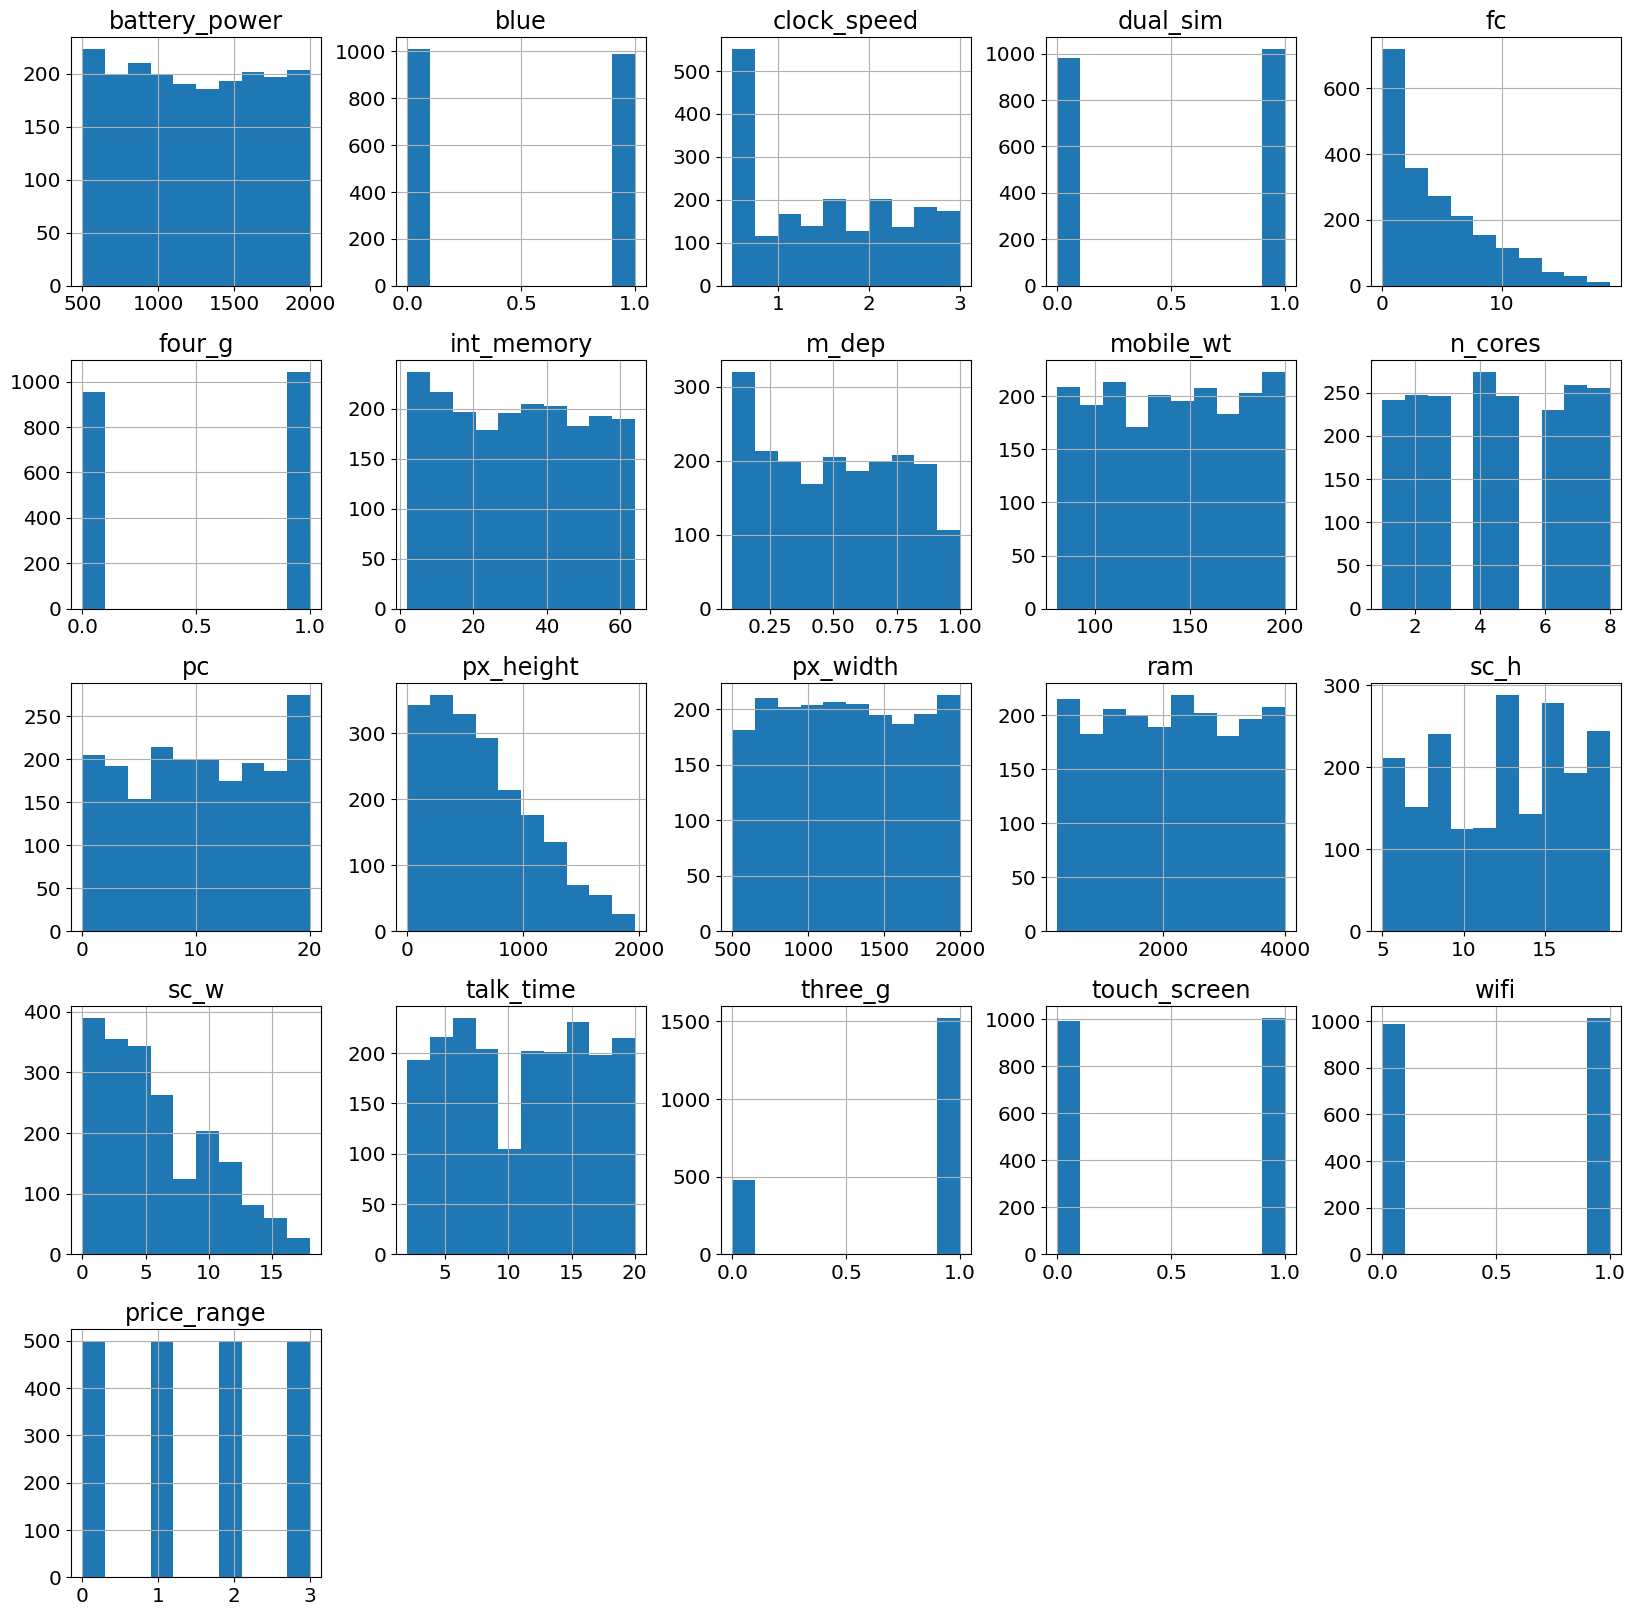

In [5]:
df.hist(figsize=(20, 20));

## Modelo Baseline

En las próximas secciones se harán distintas pruebas sobre la efectividad de la reducción de la dimensionalidad en las puntuaciones de un modelo de ML supervisado. 

Es por ello que establecemos un valor original sobre el cual se pretende obtener mejoras.

In [6]:
bs_score = score_dataset(df.drop(columns='price_range'), df['price_range'])
print("En el modelo BASELINE se obtiene un accuracy de {:.4f}".format(bs_score))

En el modelo BASELINE se obtiene un accuracy de 0.9075


# Reducción de la Dimensionalidad

La reducción de la dimensionalidad se puede hacer por
   1. Selección
       * % Valores Ausentes
       * Varianza
       * Intercorrelación
       * Relación con Target


   2. Transformación
       * Análisis de Componentes Principales
       * Ingeniería de Variables

## Selección

### Valores Ausentes

Este conjunto de datos está rigurosamente informado variable a variable y ha sido limpiado previamente por el autor, por lo que la falta de información en forma de valores missing no es un criterio válido para la selección de variables.

In [7]:
df.isna().sum()

battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
price_range      0
dtype: int64

### Varianza

Es frecuente que encontremos variables cuya variación es tan baja, que realmente no supone de ayuda a los algoritmos a la hora de tomar decisiones, sirviendo únicamente para aumentar la dimensión del espacio e, incluso, introducir ruido estadístico o errores de redondeo.

Una buena manera de medir la variabilidad de una variable, es usando la coeficiente de variación $C_V$ dado por 

$$
C_V = \dfrac{\sigma}{|\overline{X}|}
$$

El coeficiente de variación se utiliza para comparar conjuntos de datos pertenecientes a poblaciones distintas. Si atendemos a su fórmula, vemos que este tiene en cuenta el valor de la media. Por lo tanto, el coeficiente de variación nos permite tener una medida de dispersión.

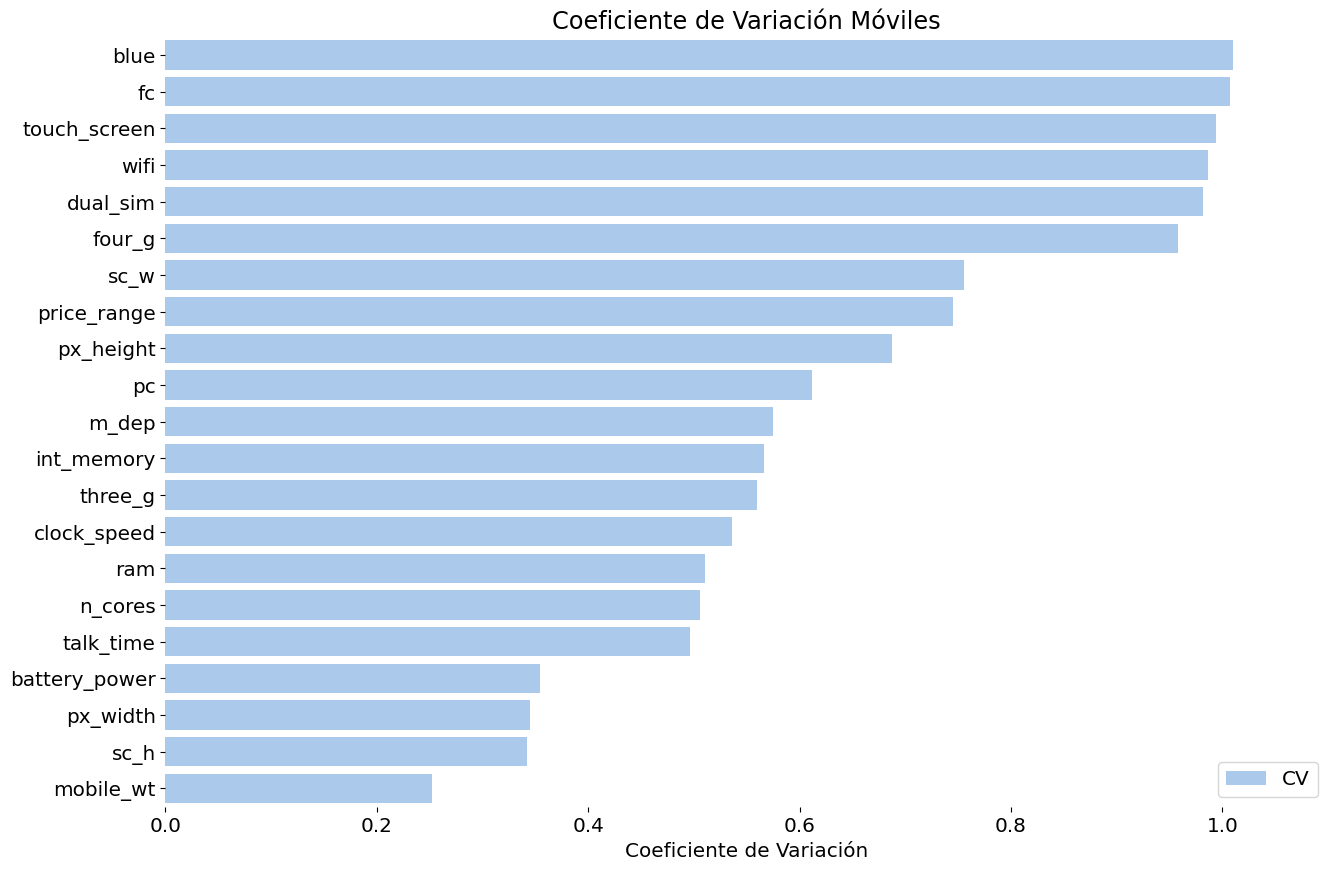

In [8]:
# Cálculo de los coeficientes de variación
# df_cv es el cálculo de Cv
df_cv = pd.DataFrame(df.std() / abs(df.mean()), columns=['CV']).reset_index()
df_cv.sort_values(['CV'], inplace=True, ascending=False)

# Representación del coeficiente de variación Mobile Data
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
sns.set_color_codes("pastel")
sns.barplot(y='index', x="CV", data=df_cv,
            label="CV", color="b");

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1.1), ylabel="",
       xlabel="Coeficiente de Variación", title="Coeficiente de Variación Móviles")
sns.despine(left=True, bottom=True)

Aparentemente, los rangos de variablidad se encuentran en valores esperables. Aquellos con menos variabilidad parecen ser los asociados al tamaño del dispositivo. 

Aunque, a priori, no vamos a eliminar ninguna variable usando este criterio, sí es cierto que sugieren la introducción de variables derivadas de estas como podrían ser medidas de superficie, volumen o densidad de pixels del dispositivo.

### Correlaciones

La correlación entre variables indica que puede existir cierta dependencia lineal entre ambas.

El signo de la pendiente de esta relación viene dado por el signo del coeficiente de correlación.

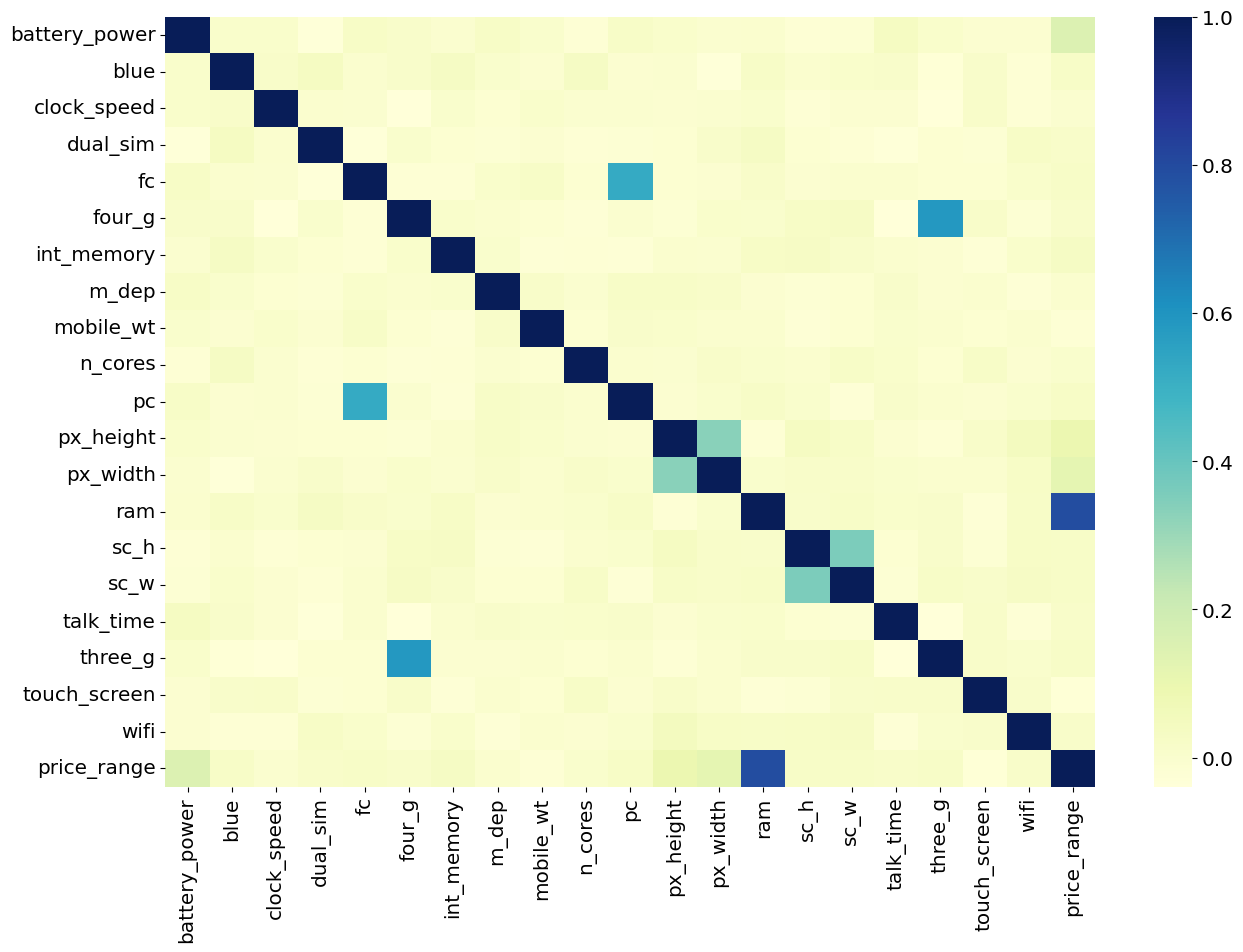

In [9]:
fig, ax = plt.subplots(1,1, figsize=(15,10))
sns.heatmap(df.corr(method='kendall'), ax=ax, cmap="YlGnBu");

Correlaciones lineales encontradas entre predictores:
   * Megapixels de la cámara frontal (fc) y de la cámara principal(pc)
   * four_g y three_g
   * px_width y px_height

Correlaciones principales encontradas con el target:
   * ram
   * px_width
   * battery_power

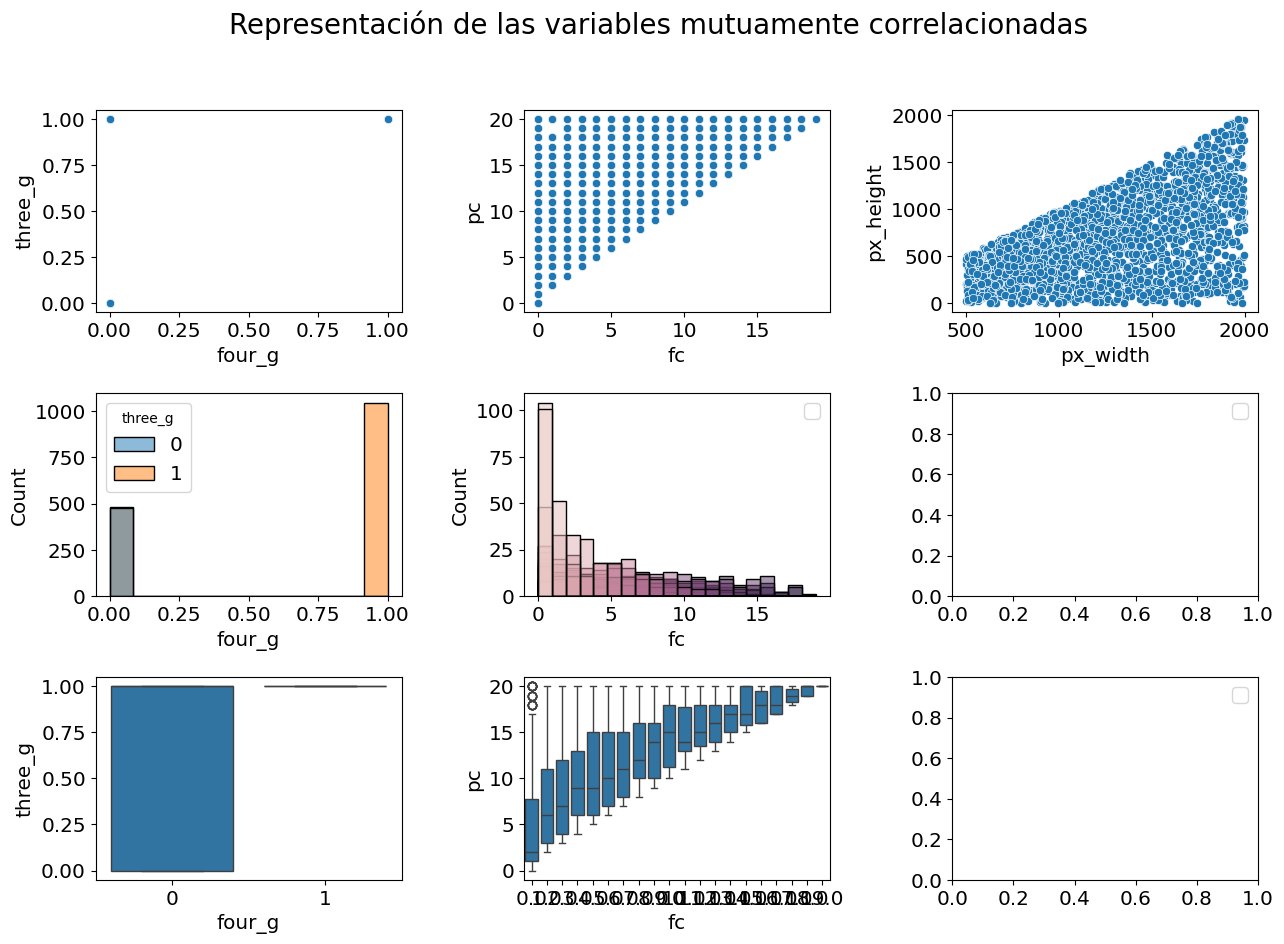

In [10]:
# Representación de las variables mutuamente relacionadas
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

# 4G vs 3G
sns.scatterplot(x='four_g', y='three_g', data=df, ax=ax[0][0])
sns.histplot(x='four_g', hue='three_g', data=df, ax=ax[1][0])
sns.boxplot(x='four_g', y='three_g', data=df, ax=ax[2][0])

# Frontal Camera vs Principal Camera
sns.scatterplot(x='fc', y='pc', data=df, ax=ax[0][1])
sns.histplot(x='fc', hue='pc', data=df, ax=ax[1][1])
sns.boxplot(x='fc', y='pc', data=df, ax=ax[2][1])
ax[1][1].legend('')

# Pixel height vs pixel width
sns.scatterplot(x='px_width', y='px_height', data=df, ax=ax[0][2])
# sns.histplot(x='px_width', hue='px_height', data=df, ax=ax[1][2])
# sns.boxplot(x='px_width', y='px_height', data=df, ax=ax[2][2])
ax[1][2].legend('')
ax[2][2].legend('')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.4, hspace=.4)

plt.suptitle("Representación de las variables mutuamente correlacionadas", fontsize=20)
plt.show()

Conclusiones: 
   * No existe el caso en el que el móvil no tiene 3G pero sí 4G, luego realmente hay 3 categorías: sin 3G ni 4G, con 3G y sin 4G, con 3G y con 4G.
   * La calidad de la cámara principal siempre es mayor que la de la cámara frontal.
   * La resolución en anchura del móvil siempre es menor que la de altura.

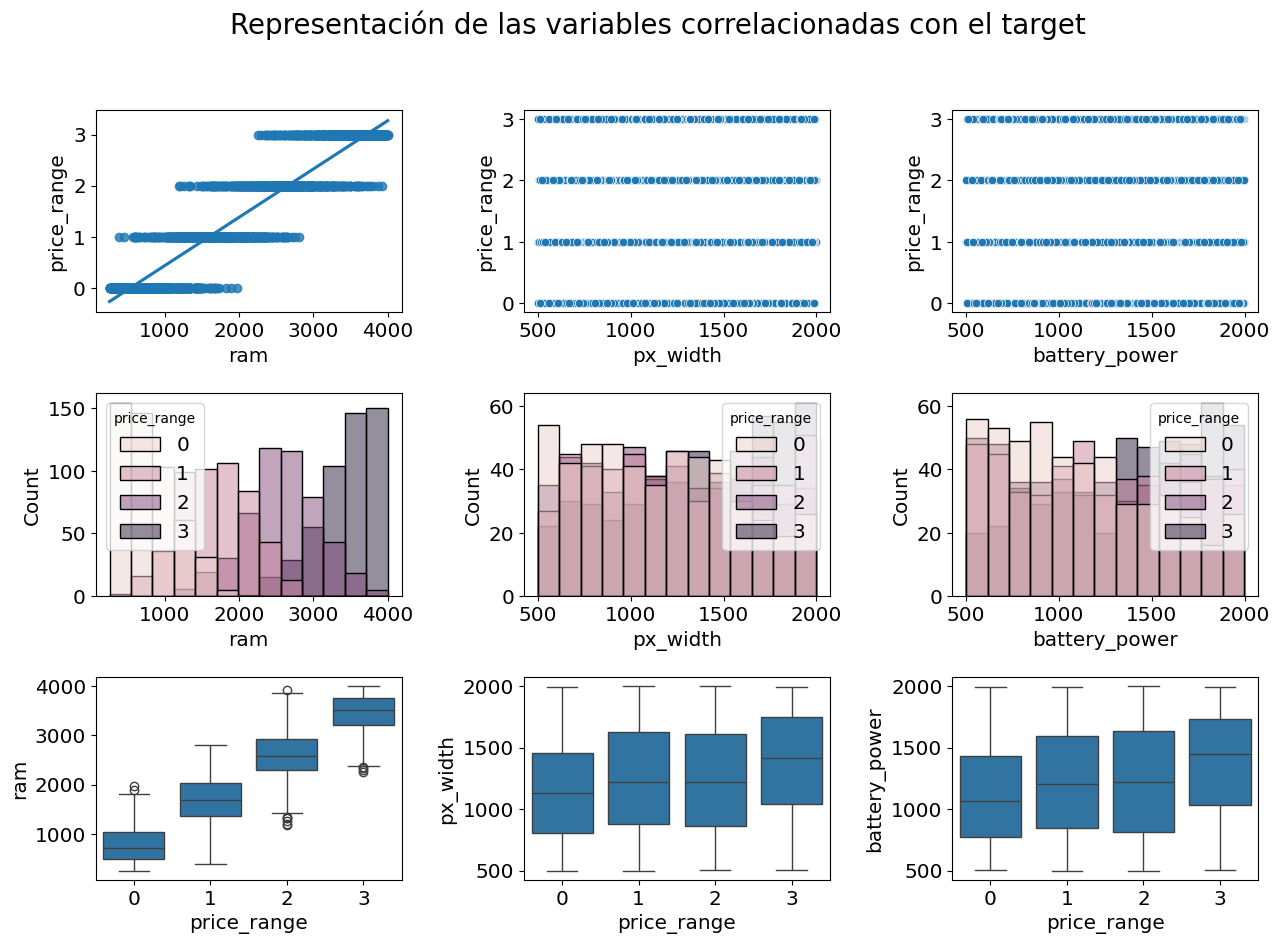

In [11]:
# Variables más correlacionadas con el target
fig, ax = plt.subplots(3, 3, figsize=(15, 10))

# RAM
sns.regplot(x='ram', y='price_range', data=df, ax=ax[0][0])
sns.histplot(x='ram', hue='price_range', data=df, ax=ax[1][0])
sns.boxplot(x='price_range', y='ram', data=df, ax=ax[2][0])

# Pixel width
sns.scatterplot(x='px_width', y='price_range', data=df, ax=ax[0][1])
sns.histplot(x='px_width', hue='price_range', data=df, ax=ax[1][1])
sns.boxplot(x='price_range', y='px_width', data=df, ax=ax[2][1])

# Battery Power
sns.scatterplot(x='battery_power', y='price_range', data=df, ax=ax[0][2])
sns.histplot(x='battery_power', hue='price_range', data=df, ax=ax[1][2])
sns.boxplot(x='price_range', y='battery_power', data=df, ax=ax[2][2])

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=.4, hspace=.4)

plt.suptitle("Representación de las variables correlacionadas con el target", fontsize=20)
plt.show()

Conclusiones:
   * La relación entre la RAM y el precio parece ser bastante lineal con pendiente positiva.
   * Respecto a la resolución en anchura y la potencia de la batería, no se puede decir que haya una relación lineal aunque sí se observa cierta monotonía

## Análisis de Componentes Principales

Es importante tener en cuenta que el PCA realmente tiene sentido cuando se aplica a variables continuas en lugar de discretas. Por otra parte, de cara a perder la mínima cantidad de información posible, puede ser interesante agrupar las variables según las características del móvil que estén describiendo.

### PCA sobre todas las variables

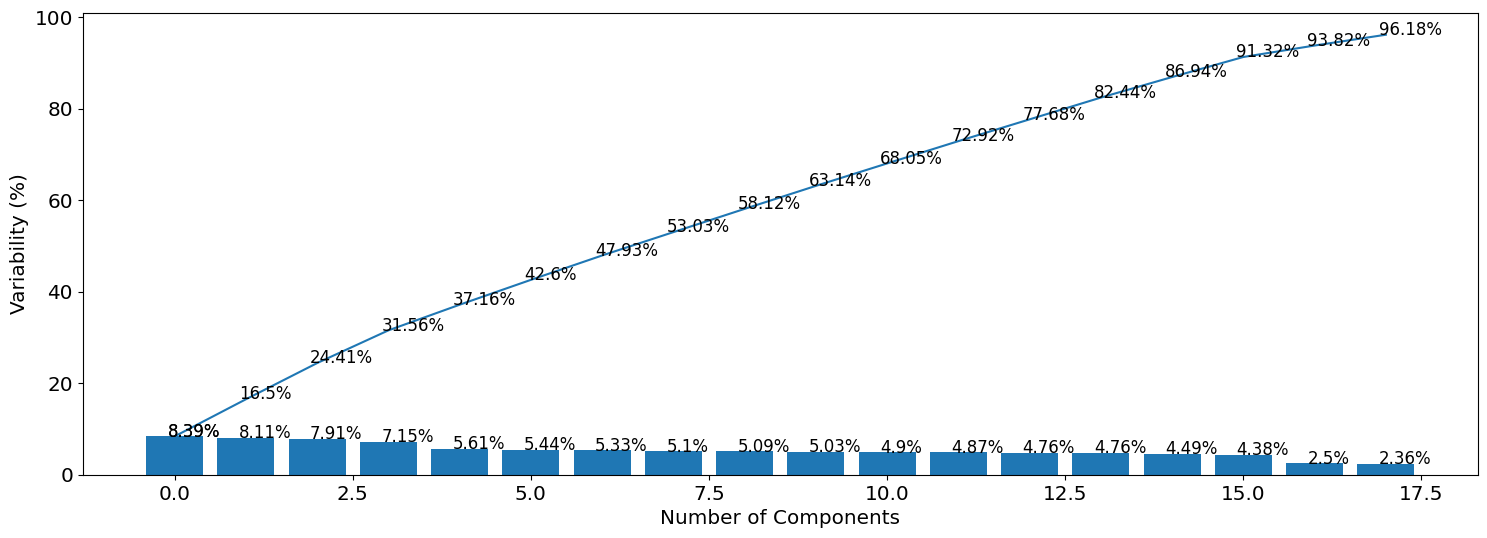

In [12]:
# entender y pasar a pipeline!
# Construcción de X e y
X = df.copy()
y = X['price_range']
X = df.drop(columns='price_range')

# Estrategia de escalado: Z-score
# sc = StandardScaler()
# X_sc = sc.fit_transform(X)

# Aplicación de PCA conservando el 95% de la varianza
# pca = PCA(n_components=0.95)
pipe_pca = make_pipeline(StandardScaler(), PCA(n_components=.95))
X_pca = pipe_pca.fit_transform(X)
pca =pipe_pca['pca']

# Representación de la varianza explicada por cada componente
# ¿Cómo mejorar este gráfico visualmente?
pca_importance(pca)

In [13]:
# Pipeline: Serie de transformaciones-modelos consecutiva
pipe = make_pipeline(StandardScaler(), PCA(n_components=0.95), XGBClassifier())

# Score del modelo tras aplicar PCA a todo
dr_score = score_dataset(X, y, pipe)
dif_bs = dr_score - bs_score
print("Reduciendo la dimensionalidad se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(dr_score, dif_bs))

Reduciendo la dimensionalidad se tiene una precisión de 0.6960 (-0.2115 sobre el baseline)


### PCA sobre ciertas variables seleccionadas 

A priori, se pueden clasificar las variables en varios grupos:
   * Continuas y Discretas
   * De rendimiento, propiedades físicas del móvil y conectividad

#### Continuas VS. Discretas

In [14]:
# Definición de X e y de nuevo
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

# Variables float (continuas)
col_float = X.select_dtypes(include=float).columns
# Repensar está línea de código
#col_int = [x for x in X.columns if x not in col_float]
col_int = X.select_dtypes(include=int).columns
print("Número original de columnas: {}\n".format(len(col_float)))

# entender
# Pipeline que se va a aplicar
pipe_float = make_pipeline(StandardScaler(), PCA(n_components=.95))
pca_trans = ColumnTransformer(transformers=[('float', pipe_float, col_float),
                                            ('int', FunctionTransformer(), col_int)])

pipe = make_pipeline(pca_trans, XGBClassifier())

# Puntuación aplicando PCA sobre las variables continuas
drnum_score = score_dataset(X, y, pipe)
difnum_bs = drnum_score - bs_score
print("Reduciendo la dimensionalidad se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(drnum_score, difnum_bs))

Número original de columnas: 14

Reduciendo la dimensionalidad se tiene una precisión de 0.7505 (-0.1570 sobre el baseline)


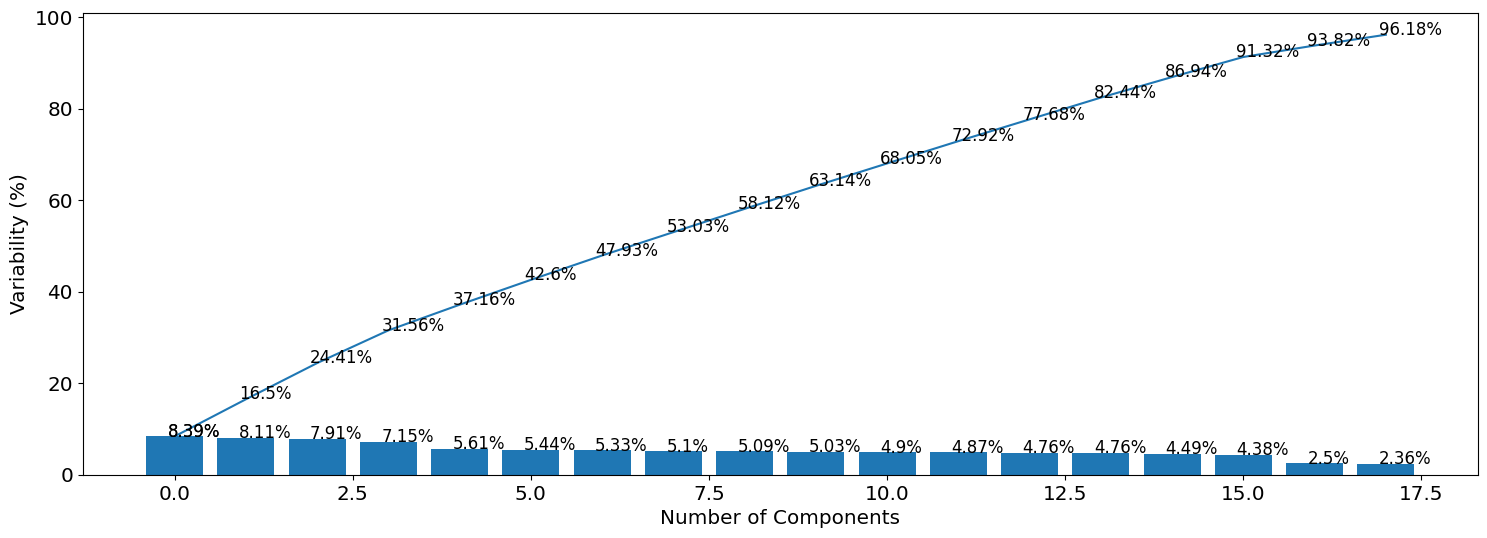

In [15]:
# hacer pca y gráfico para las tipo float que explican al menos el 95% 
pca_importance(pca)

In [16]:
# Sacamos la matriz de pesos del PCA
pca = pipe_float['pca']
component_names = ['PCA{}'.format(i) for i in range(1, pca.components_.shape[0] + 1)]
loadings = pd.DataFrame(
                            pca.components_.T,  # transpose the matrix of loadings
                            columns=component_names,  # so the columns are the principal components
                            index=X[col_float].columns,  # and the rows are the original features
                        )
fig, ax = plt.subplots(1,1, figsize=(16, 9))
sns.heatmap(loadings, annot=True, ax=ax, annot_kws={"size": 14})

AttributeError: 'PCA' object has no attribute 'components_'

**Conclusión**: Aunque claramente los resultados mejoran con respecto a realizar el PCA sobre todas las variables, seguimos teniendo un modelo peor que el modelo base porque las variables sobre las que se aplica, en general, no están correlacionadas.

#### Variables mutuamente correlacionadas

In [ ]:
import pandas as pd

df = pd.DataFrame(X_da)

<bound method DataFrame.corr of       battery_power  blue  clock_speed  dual_sim    fc  four_g  int_memory  \
0             842.0     0          2.2         0   1.0       0         7.0   
1            1021.0     1          0.5         1   0.0       1        53.0   
2             563.0     1          0.5         1   2.0       1        41.0   
3             615.0     1          2.5         0   0.0       0        10.0   
4            1821.0     1          1.2         0  13.0       1        44.0   
5            1859.0     0          0.5         1   3.0       0        22.0   
6            1821.0     0          1.7         0   4.0       1        10.0   
7            1954.0     0          0.5         1   0.0       0        24.0   
8            1445.0     1          0.5         0   0.0       0        53.0   
9             509.0     1          0.6         1   2.0       1         9.0   
10            769.0     1          2.9         1   0.0       0         9.0   
11           1520.0     1       

In [ ]:
tumadre(df)

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [ ]:
# Redefinimos X e y
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

# Seleccionamos las variables sobre las que queremos aplicar el PCA
# Una forma menos hardcodeada?

col_corr = ['fc', 'pc', 'px_width', 'px_height']
col_id = [x for x in X.columns if x not in col_corr]
print("Número original de columnas: {}\n".format(len(col_corr)))

# Seleccionamos el número de variables con el que nos queremos quedar
# entender
pipe_float = make_pipeline(StandardScaler(), PCA(n_components=2))
pca_trans = ColumnTransformer(transformers=[('pca', pipe_float, col_corr),
                                            ('id', FunctionTransformer(), col_id)])
pipe = make_pipeline(pca_trans, XGBClassifier())

drnum_score = score_dataset(X, y, pipe)
difnum_bs = drnum_score - bs_score
print("Reduciendo la dimensionalidad se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(drnum_score, difnum_bs))

Número original de columnas: 4

Reduciendo la dimensionalidad se tiene una precisión de 0.9155 (0.0080 sobre el baseline)


In [ ]:
score_dataset(X, y)

0.9075

In [ ]:
# Probar xgboost sin pca pero con el ColumnTransformer similar

In [ ]:
pca, _ = do_pca(X[col_corr], n=.95)
pca_importance(pca)

AttributeError: 'DataFrame' object has no attribute 'fit'

In [ ]:
# debuggear
# crear función
col_corr = list(set(lista_corr))
pipe_float.fit(X[col_corr])
pca = pipe_float["pca"]
component_names = ['PCA{}'.format(i) for i in range(1, pca.components_.shape[0] + 1)]
loadings = pd.DataFrame(
                        pca.components_.T,  # transpose the matrix of loadings
                        columns=component_names,  # so the columns are the principal components
                        index=X[col_corr].columns,  # and the rows are the original features
                    )
fig, ax = plt.subplots(1,1, figsize=(10, 5))
sns.heatmap(loadings, annot=True, ax=ax, annot_kws={"size": 14});

AttributeError: 'PCA' object has no attribute 'components_'

#### Otras Candidatas

In [ ]:
# Convertir en función!
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

col_float = ['clock_speed', 'int_memory',  'ram', 'n_cores']
print("Número original de columnas: {}\n".format(len(col_float)))
pipe_float = make_pipeline(StandardScaler(), PCA(n_components=.95))

pca_trans = ColumnTransformer(transformers=[('float', pipe_float, col_float),
                                            ('int', FunctionTransformer(), [x for x in X.columns if x not in col_float])])
pipe = make_pipeline(pca_trans, XGBClassifier())

drnum_score = score_dataset(X, y, pipe)
difnum_bs = drnum_score - bs_score
print("Reduciendo la dimensionalidad se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(drnum_score, difnum_bs))

Número original de columnas: 4

Reduciendo la dimensionalidad se tiene una precisión de 0.8010 (-0.1065 sobre el baseline)


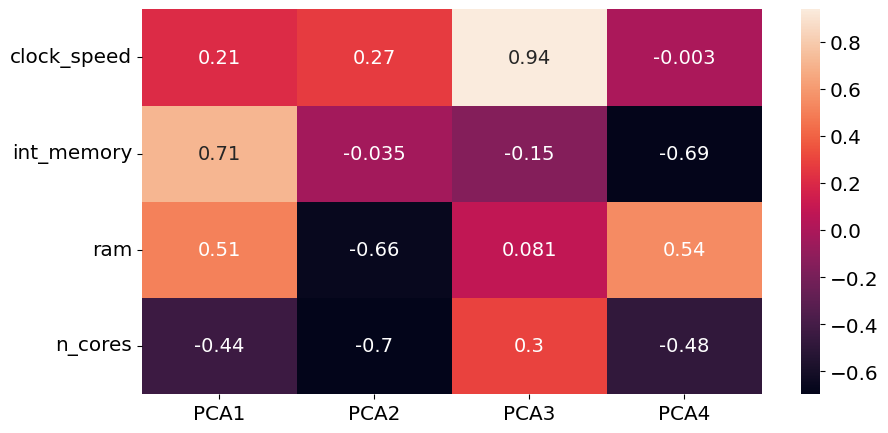

In [ ]:
# mostrar gráfico y tabla
def pinta_pca(pipe_float, col_corr):
    pipe_float.fit(X[col_corr])
    pca = pipe_float["pca"]
    component_names = ['PCA{}'.format(i) for i in range(1, pca.components_.shape[0] + 1)]
    loadings = pd.DataFrame(
                            pca.components_.T,  # transpose the matrix of loadings
                            columns=component_names,  # so the columns are the principal components
                            index=X[col_corr].columns,  # and the rows are the original features
                        )
    fig, ax = plt.subplots(1,1, figsize=(10, 5))
    sns.heatmap(loadings, annot=True, ax=ax, annot_kws={"size": 14});
pinta_pca(pipe_float, col_float)

### PCA para Ingeniería de variables

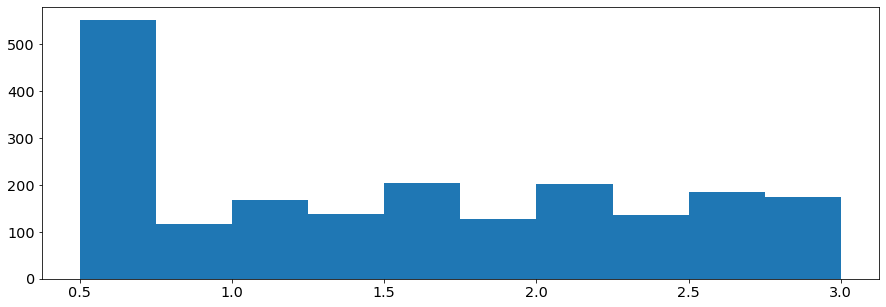

In [ ]:
plt.hist(df['clock_speed']);hbvc

In [ ]:
len(df.columns)

21

In [ ]:
df.columns

Index(['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g',
       'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height',
       'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g',
       'touch_screen', 'wifi', 'price_range'],
      dtype='object')

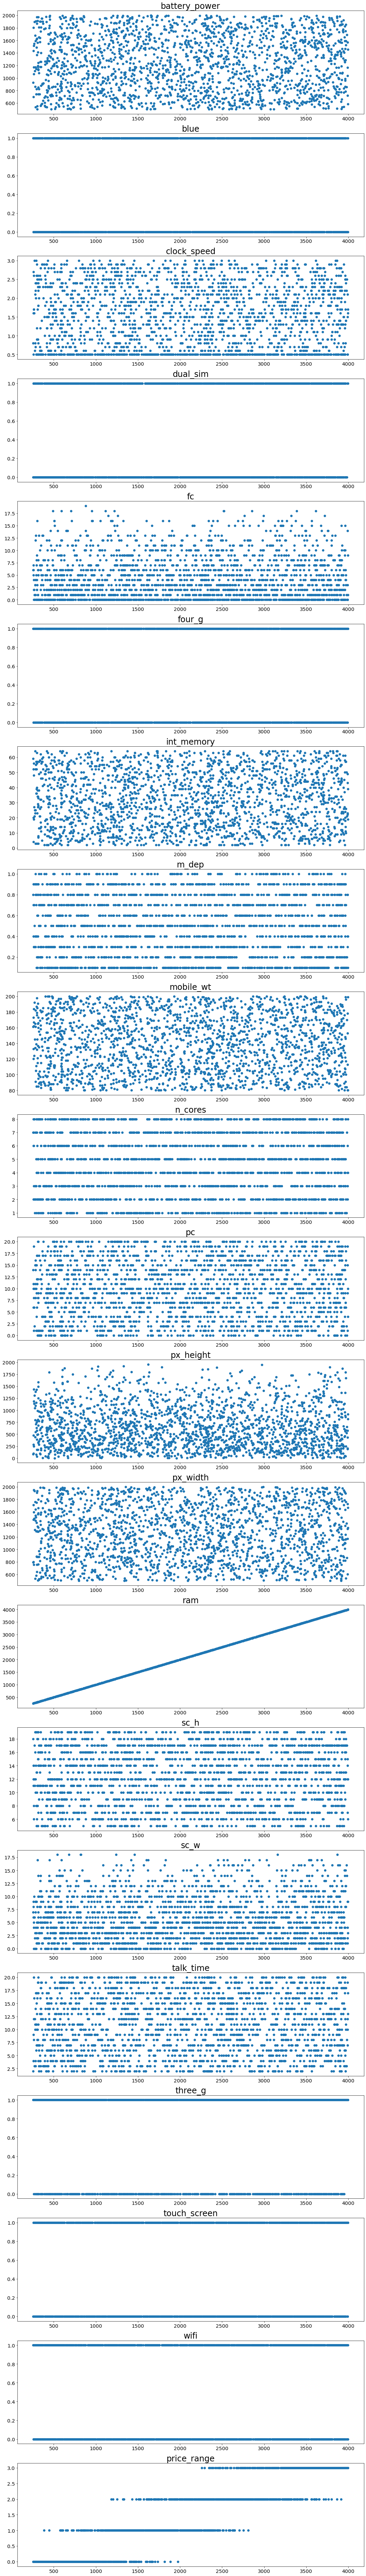

In [ ]:
# plt.subplots(len(df.columns), 1)
plt.figure(figsize=(15, 5 * len(df.columns)))
for i, col in enumerate(df.columns):
    plt.subplot(len(df.columns), 1, i+1)
    plt.scatter(df['ram'], df[col])
    plt.title(col, fontsize=24)

plt.tight_layout()

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

X['camera_prod'] = (X['fc'] + X['pc']) ** 2
X['sc_w'] = np.where(X['sc_w'].values == 0, X['sc_h'] * (9/16), X['sc_w'].values)
X['px_surf_dens'] = X['px_width'] * X['px_height'] / (X['sc_w'] * X['sc_h'])
X['px_num'] = X['px_width'] * X['px_height']

X.drop(columns=['fc', 'pc'], inplace=True)

# X['conn'] = X['four_g'] + X['three_g'] + X['wifi'] + X['blue']
# X.drop(columns=['three_g', 'wifi'], inplace=True)

drnum_score = score_dataset(X, y)
difnum_bs = drnum_score - bs_score
print("Haciendo ingeniería de predictores basada en PCA se tiene una precisión de {:.4f} ({:.4f} sobre el baseline)".format(drnum_score, difnum_bs))

Haciendo ingeniería de predictores basada en PCA se tiene una precisión de 0.9165 (0.0090 sobre el baseline)


In [ ]:
# probar lo anterior + pca de 4 más correlacionadas

# Clustering

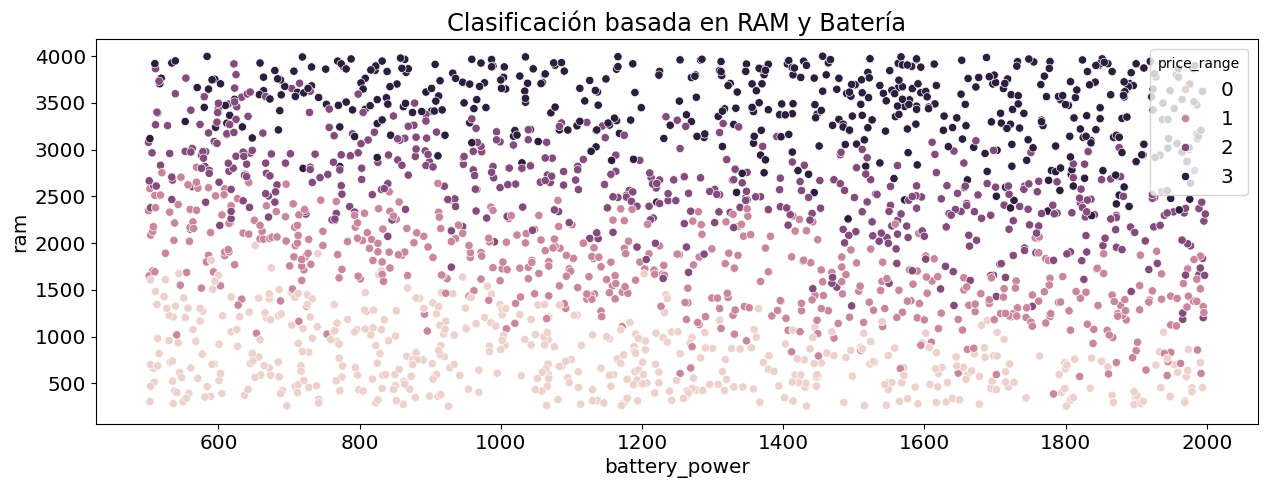

In [ ]:
ax2 = sns.scatterplot(x='battery_power', y='ram', hue='price_range', data=df)
ax2.set(title='Clasificación basada en RAM y Batería');
plt.show()

## Hierarchical Clustering

In [ ]:
import numpy as np

from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering


def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

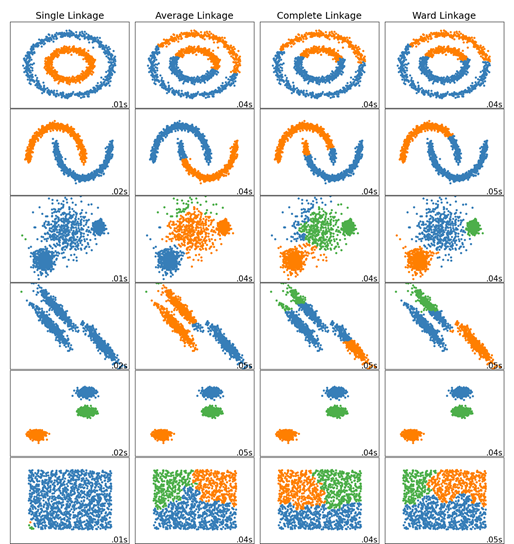

### Ward

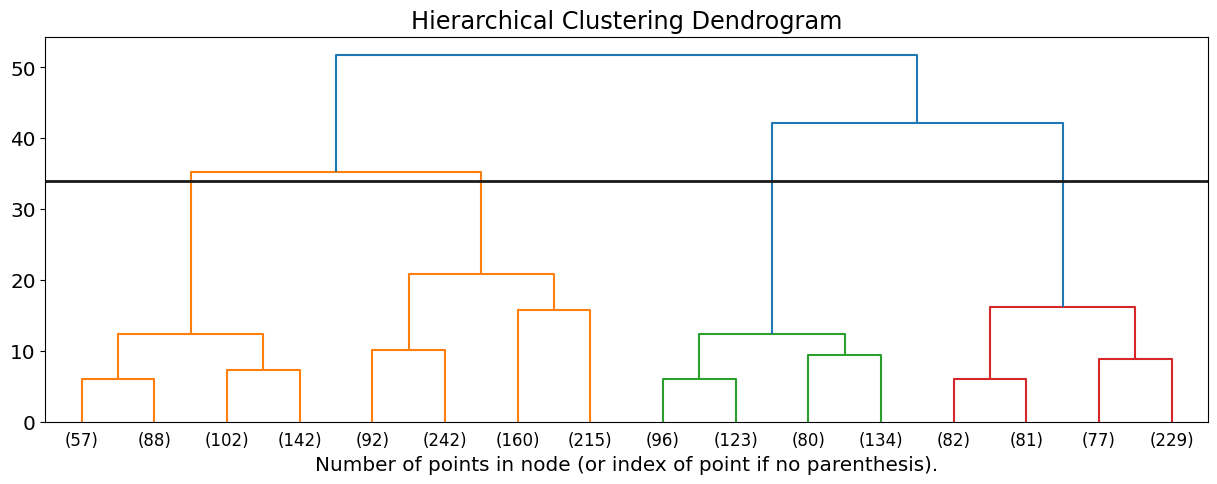

In [ ]:
# ¿podemos meterlo en una pipeline?
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)

model = model.fit(X_sc)
plt.title('Hierarchical Clustering Dendrogram')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=34, color='k', linestyle='-', linewidth=2)
plt.show()

### Single Linkage

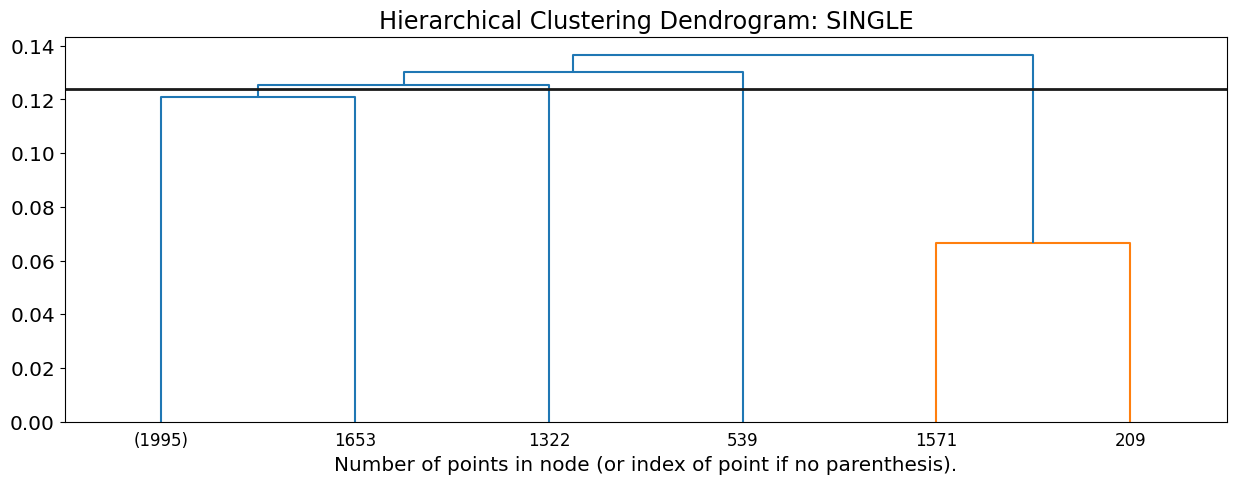

In [ ]:
# Parece que vamos a intentar probar todos los tipos de linkage... Mejor en una función!
X= df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='single')

model = model.fit(X_sc)

plt.title('Hierarchical Clustering Dendrogram: SINGLE')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=.124, color='k', linestyle='-', linewidth=2)
plt.show()

### Complete Linkage

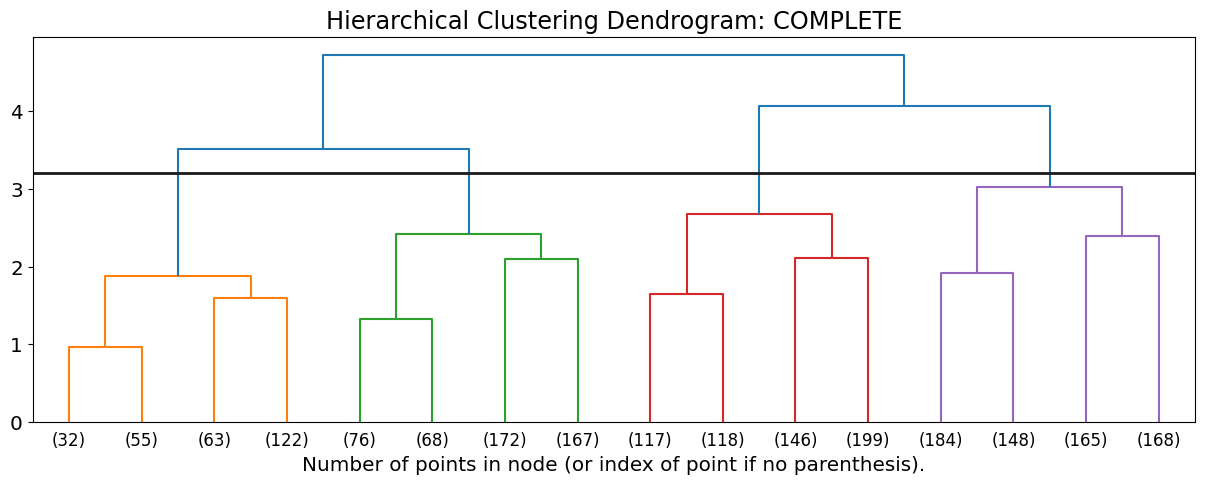

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='complete')

model = model.fit(X_sc)

plt.title('Hierarchical Clustering Dendrogram: COMPLETE')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=3.2, color='k', linestyle='-', linewidth=2)
plt.show()

### Average Linkage

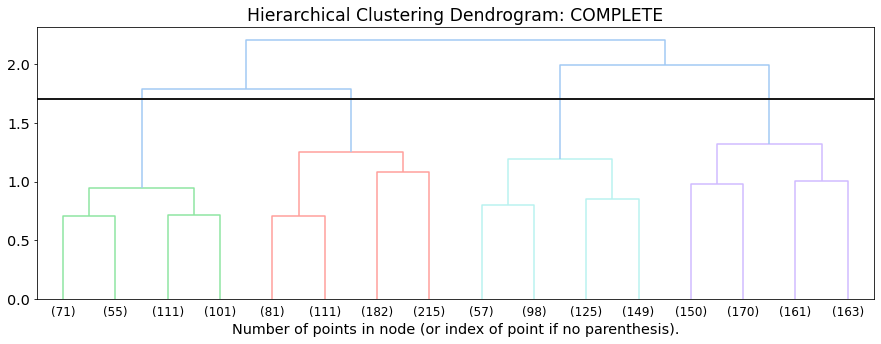

In [ ]:
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')

model = model.fit(X_sc)

plt.title('Hierarchical Clustering Dendrogram: COMPLETE')
# plot the top three levels of the dendrogram
plot_dendrogram(model, truncate_mode='level', p=3)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.axhline(y=1.7, color='k', linestyle='-', linewidth=2)
plt.show()

## Non Hierarchical

### K-Means

cluster
0    510
1    529
2    519
3    442
Name: count, dtype: int64


METRICS:
Silhouette Score: 0.41



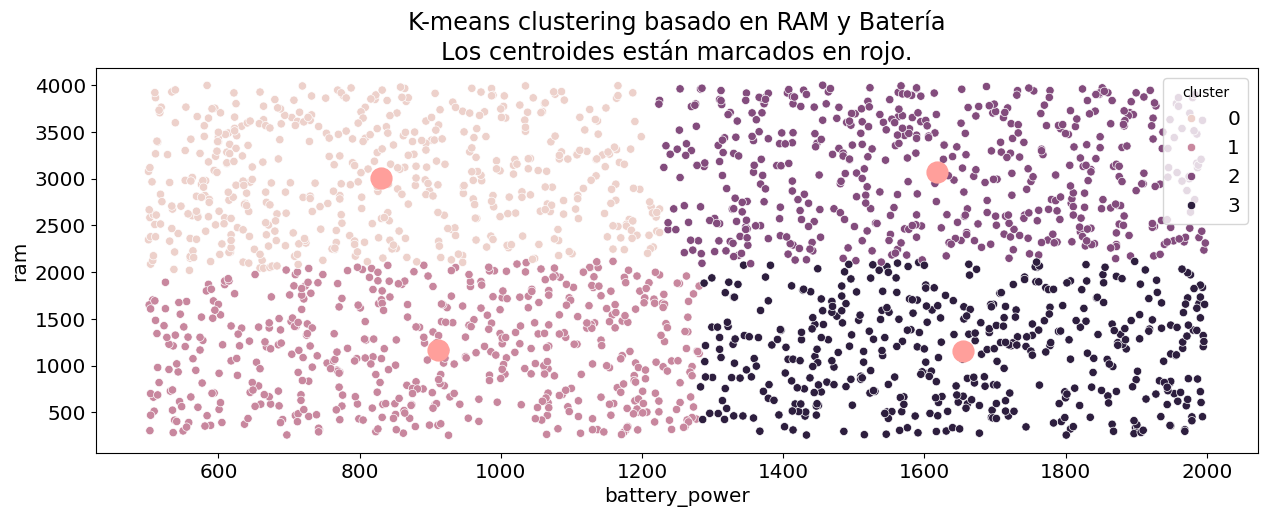

In [ ]:
#Este es solo un ejemplo. 
# Intentemos crear una (mejor varias) función flexible para probar diversas combinaciones
# Creemos también una tabla con cada cluster, media de variables, std...
from sklearn.cluster import KMeans
X = df.copy()
y = X['price_range']
X.drop(columns='price_range', inplace=True)

sc = StandardScaler()
X_sc = sc.fit_transform(X[['ram', 'battery_power']])

kmeans = KMeans(n_clusters=4, init="k-means++", n_init=4)
kmeans.fit(X_sc)

X['cluster'] = kmeans.labels_

print(X.cluster.value_counts().sort_index())

ari = adjusted_rand_score(X['cluster'], y)
sil = silhouette_score(X_sc, labels=X['cluster'])
print('\n\nMETRICS:')
print('Silhouette Score: {:.2f}\n'.format(sil))

ax = sns.scatterplot(x='battery_power', y='ram', hue='cluster', data=X)
ax.set(title='Clustering based on RAM and Battery');

centroids = sc.inverse_transform(kmeans.cluster_centers_)

plt.scatter(centroids[:, 1], centroids[:, 0], marker="o", s=169, linewidths=3,
            color="r", zorder=10)
plt.title("K-means clustering basado en RAM y Batería\n"
          "Los centroides están marcados en rojo.")
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()


## Métricas

Evaluar el rendimiento de un algoritmo de agrupación no es tan trivial como contar el número de errores o la precisiónde un algoritmo de clasificación supervisada. 

En particular, cualquier métrica de evaluación no debería tener en cuenta los valores absolutos de las etiquetas de los clústeres, sino más bien si esta agrupación define separaciones de los datos similares a algún conjunto de clases de la verdad básica o satisface alguna suposición como que los miembros que pertenecen a la misma clase son más similares que los miembros de clases diferentes según alguna métrica de similitud.
 

### Internas

#### Silhouette Score

El Silhouette Score es un ejemplo de métrica que indica cómo de bien definidos están los clusters sin conocer las etiquetas reales.

* a: distancia media entre un punto y todos los demás en la misma clase.
* b: distancia media entre un punto y todos los demás en el cluster más cercano.

$$s = \dfrac{b - a}{max(a, b)}$$

In [ ]:
# pintar

#### Inercia

El algoritmo K-Means busca la elección de centroides que minimiza la **inercia** o **suma de cuadrados internas del cluster**:
$$
\sum_{i=0}^{n}\min_{\mu_j \in C}(||x_i - \mu_j||^2)
$$

Se define así la **inercia** como la suma de las distancias de cada punto a su centroide correspondiente

La inercia puede reconocerse como una medida de la coherencia interna de las agrupaciones. Pero tiene varios inconvenientes:

* La inercia supone que los conglomerados son convexos e isótropos, lo que no siempre es el caso. Responde mal a los conglomerados alargados o a las variedades con formas irregulares.

* La inercia no es una métrica normalizada: sólo sabemos que los valores más bajos son mejores y que cero es óptimo. Pero en espacios de muy alta dimensión, las distancias euclidianas tienden a inflarse (es un caso de la llamada "maldición de la dimensionalidad"). La ejecución de un algoritmo de reducción de la dimensionalidad, como el análisis de componentes principales (PCA), antes de la agrupación de k-means puede aliviar este problema y acelerar los cálculos.

In [ ]:
# Dado un estimador entrenado de KMeans como kmeans, es inmediato obtener la inercia

INERTIA KMEANS: 742.9528


### Método del Codo

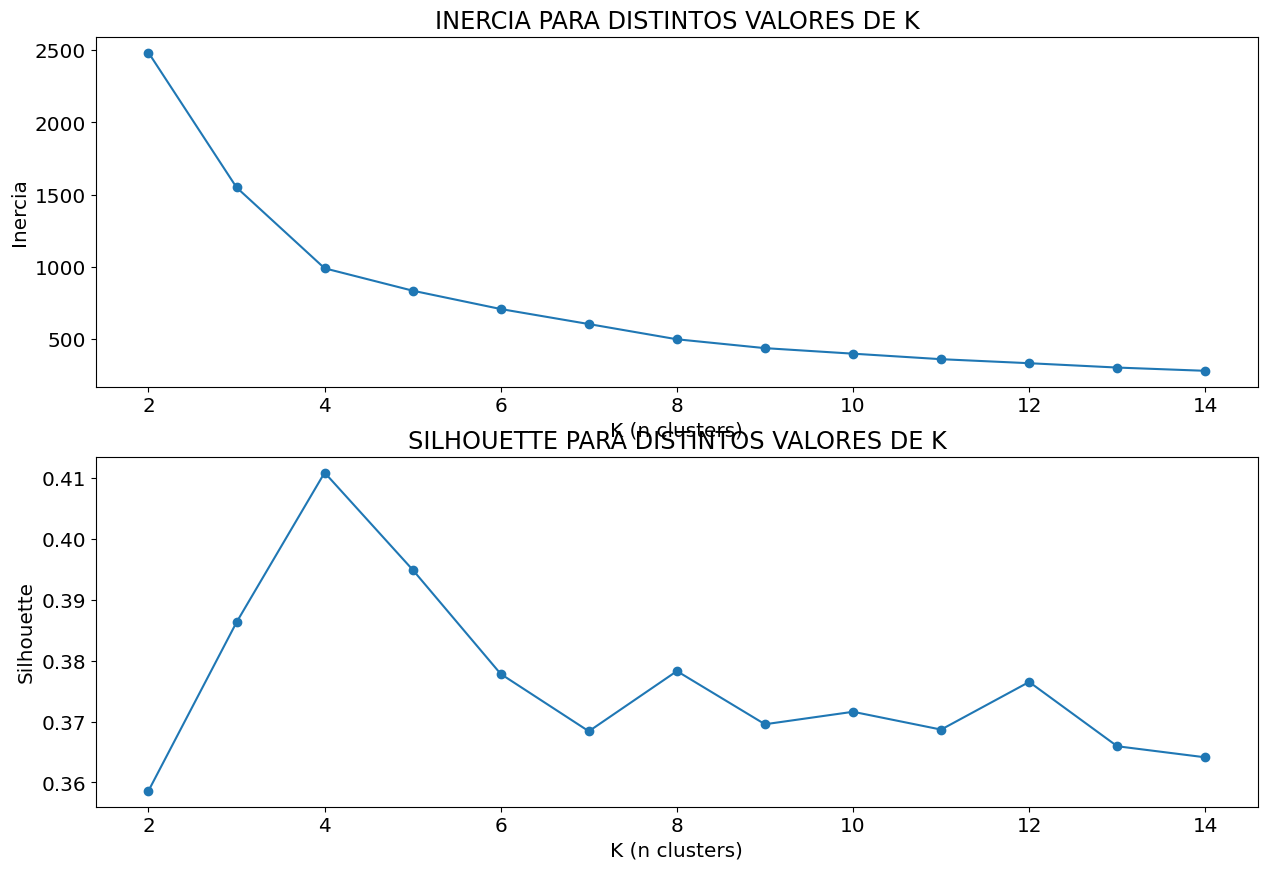

In [ ]:
# X = df.copy()
# y = X['price_range']
# X.drop(columns='price_range', inplace=True)

# sc = StandardScaler()
# X_sc = sc.fit_transform(X[['ram', 'battery_power']])

# Código para rellenar los gráficos!

fig, ax = plt.subplots(2, 1, figsize=(15, 10))  
ax[0].plot(range_n_clusters, ls_inertia, 'o-')
ax[0].set(title='INERCIA PARA DISTINTOS VALORES DE K', 
       xlabel='K (n clusters)',
       ylabel='Inercia');

ax[1].plot(range_n_clusters, ls_sil, 'o-')
ax[1].set(title='SILHOUETTE PARA DISTINTOS VALORES DE K', 
       xlabel='K (n clusters)',
       ylabel='Silhouette');

# Feature Selection

In [ ]:
# Probar Variance Threshold
from sklearn.feature_selection import VarianceThreshold

In [ ]:
# Probar SelectKBest
from sklearn.feature_selection import SelectKBest, f_classif

In [ ]:
# Probar por feature importance
from sklearn.feature_selection import SelectFromModel


In [ ]:
#Probar RFE
from sklearn.feature_selection import RFE